In [1]:
%matplotlib inline
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
print(device)

cuda


In [5]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), 
                             (0.5, 0.5, 0.5))
    ])
    image = in_transform(image).unsqueeze(0)
    
    return image

In [8]:
content = load_image('City.jpg').to(device)
style = load_image('StarryNight.jpg', shape=content.shape[-2:]).to(device)

In [9]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

(-0.5, 599.5, 399.5, -0.5)

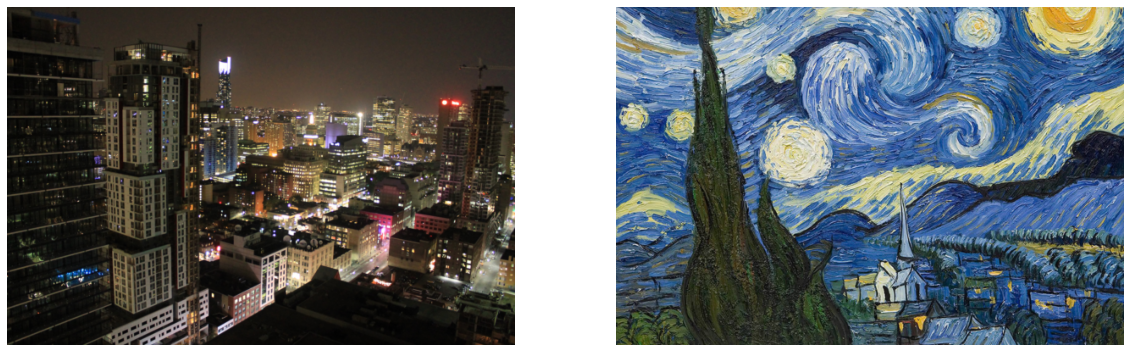

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')

In [11]:
def get_features(image, model):
    
    layers = {'0': 'conv1_1',
              '5': 'conv2_1',
              '10': 'conv3_1',
              '19': 'conv4_1',
              '21': 'conv4_2', #content extraction
              '28': 'conv5_1'}
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
            
    return features
            

In [12]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

In [13]:
content_features.keys()

dict_keys(['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv4_2', 'conv5_1'])

In [14]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size() # batch, depth, height, width
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

In [15]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [16]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1
style_weight = 1e6


In [17]:
target = content.clone().requires_grad_(True).to(device)

In [18]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))

capture_frame = steps/300
counter = 0

Total loss:  2887558.25
Iteration:  300


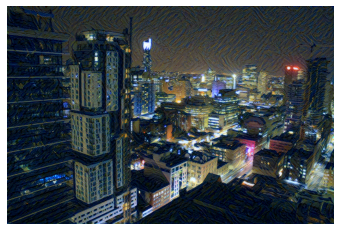

Total loss:  949927.125
Iteration:  600


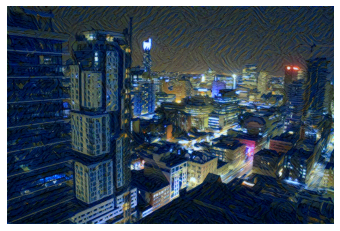

Total loss:  658526.4375
Iteration:  900


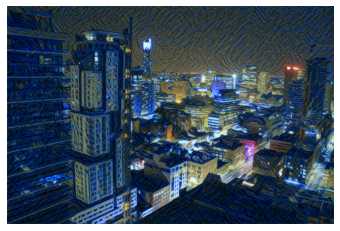

Total loss:  510594.875
Iteration:  1200


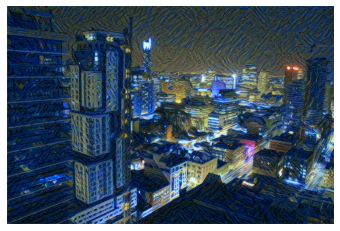

Total loss:  400952.96875
Iteration:  1500


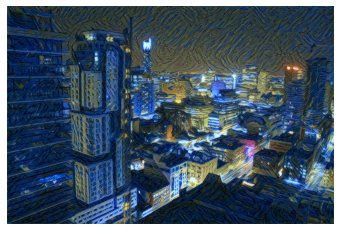

Total loss:  315178.90625
Iteration:  1800


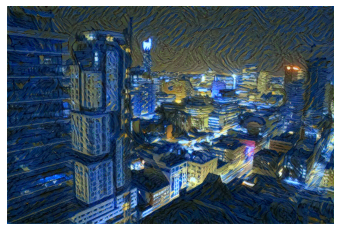

Total loss:  247106.75
Iteration:  2100


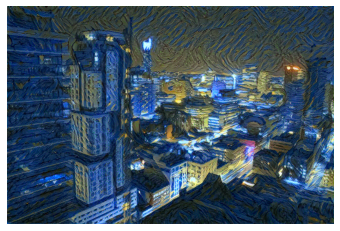

In [19]:
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        _, d, h, w =target_feature.shape
        style_loss += layer_style_loss/ (d*h*w)
        
    total_loss = content_loss*content_weight + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()
        
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1
        
        

(-0.5, 599.5, 399.5, -0.5)

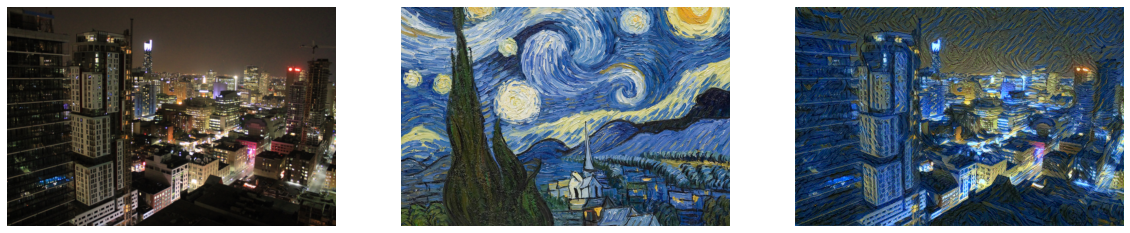

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')

In [30]:
import cv2 

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img*255
  img = np.array(img, dtype = np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [32]:
import cv2

frame_height, frame_width, _ = im_convert(target).shape
vid = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

for i in range(0, 300):
  img = image_array[i]
  img = img * 255
  img = np.array(img, dtype=np.uint8)
  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  vid.write(img)

vid.release()

In [24]:
!ls

City.jpg     MonaLisa.jpg  sample_data	StarryNight.jpg
Colours.jpg  Roses.jpg	   Sarmad.jpg


In [33]:
from google.colab import files
files.download('output.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>